# Data Mining & Analytics: Twitter Depression

---



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string

from sklearn.metrics import accuracy_score

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

#from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

pd.set_option('max_rows', None)

!pip install nltk
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords

import re
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /opt/conda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:

Data = pd.read_csv('Mental-Health-Twitter.csv')
Y = Data[['post_id','label']]

In [3]:
twitter_text = Data[['post_text','label']]
twitter_text.head()

,post_text,label
0,It's just over 2 years since I was diagnosed w...,1
1,"It's Sunday, I need a break, so I'm planning t...",1
2,Awake but tired. I need to sleep but my brain ...,1
3,RT @SewHQ: #Retro bears make perfect gifts and...,1
4,It’s hard to say whether packing lists are mak...,1


In [4]:
from textblob import Word
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()
nltk.download("wordnet")

sw = stopwords.words('english')
def normalize_opinion(text):
  
    # define emojis
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    
    
    # lowercase
    s = text.lower()
   
    # Change 'n't to 'not'
    s = re.sub(r"n\'t", " not", s)
    s = re.sub(r"n\’t", " not", s)
    # Change ''s to 'is'
    s = re.sub(r"\'s", " is", s)
    s = re.sub(r"\’s", " is", s)
    # Change ''ll to 'will'
    s = re.sub(r"\'ll", " will", s)
    s = re.sub(r"\’ll", " will", s)
    # Change ''m to 'am'
    s = re.sub(r"\'m", " am", s)
    s = re.sub(r"\’m", " am", s)
    # Change ''ve to 'have'
    s = re.sub(r"\'ve", " have", s)
    s = re.sub(r"\’ve", " have", s)
    # Change ''re to 'are'
    s = re.sub(r"\'re", " are", s)
    s = re.sub(r"\’re", " are", s)
    
    s = re.sub(r'[0-9]', '', s)

    # Remove @name - tags/mentions
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Remove hashtags
    s = re.sub(r'#[A-Za-z0-9_]+', ' ', s)
    # Remove web links
    s = re.sub(r'http\S+', ' ', s)
    
    # Remove emojis
    s = emoji_pattern.sub(r'', s)
    
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    
    s = [word.lower() for word in s.split() if word.lower() not in sw]
   
    s = " ".join(s) #removing stopwords
    

    # Remove words of length shorter than 2   
    s = [i for i in s.split() if len(i)>2]
    s = ' '.join(s)

    return  s


[nltk_data] Downloading package omw-1.4 to /opt/conda/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /opt/conda/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
twitter_text['normalized_text'] = twitter_text['post_text'].apply(lambda x: normalize_opinion(x))

In [6]:
top_40 =twitter_text['normalized_text'] .str.split(expand=True).stack().value_counts()
indicators = top_40.index.tolist()[:5000]

#indicators 

In [7]:
def indication_find(x):
    list_of_words = x.split(' ')
    out_data = [] # initialize an empty list
    for word in list_of_words :
        # remove punctuations with strip() 
         if word.strip('.,!?') in indicators:
            out_data.append(word)
    return str(out_data)

twitter_text['keys']  = twitter_text['normalized_text'] .apply(indication_find)

In [8]:
twitter_text = pd.concat([twitter_text], axis=1)
twitter_df =twitter_text[['keys']]

In [9]:
X_train, X_test, y_train, y_test = train_test_split( twitter_df['keys'] .tolist() ,
                                                    Y["label"].tolist(), test_size=0.33, random_state=42)

In [10]:
# Naive Bayes Classifier 
# Scikit-learn includes several variants of this classifier;
# The most suitable for text might be the multinomial

from sklearn.naive_bayes import MultinomialNB

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)


from sklearn.metrics import classification_report
y_pred_nb = nb.predict(X_test)

print('Naive Bayes accuracy:',  accuracy_score(y_pred_nb, y_test))
print(classification_report(y_test, y_pred_nb))

accuracy: 0.7412121212121212
              precision    recall  f1-score   support

           0       0.75      0.72      0.73      3271
           1       0.73      0.76      0.75      3329

    accuracy                           0.74      6600
   macro avg       0.74      0.74      0.74      6600
weighted avg       0.74      0.74      0.74      6600



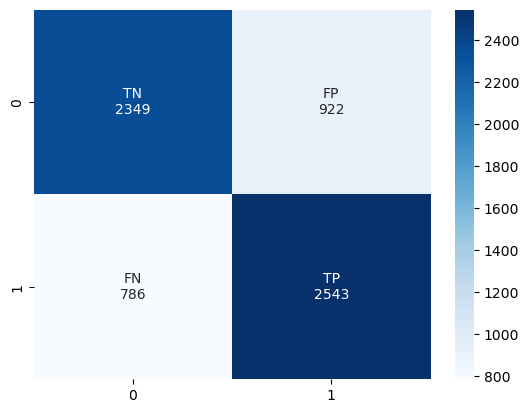

In [11]:
import seaborn as sns
cnf_matrix = confusion_matrix(y_test,y_pred_nb)
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues');

In [12]:
# Linear support vector machine (aka: SVMs)
# Effective in high dimensional spaces.

from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, 
                random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

y_pred_svm = sgd.predict(X_test)

print('SVMs accuracy %s' % accuracy_score(y_pred_svm, y_test))
print(classification_report(y_test, y_pred_svm))

accuracy 0.7112121212121212
              precision    recall  f1-score   support

           0       0.82      0.54      0.65      3271
           1       0.66      0.88      0.75      3329

    accuracy                           0.71      6600
   macro avg       0.74      0.71      0.70      6600
weighted avg       0.74      0.71      0.70      6600



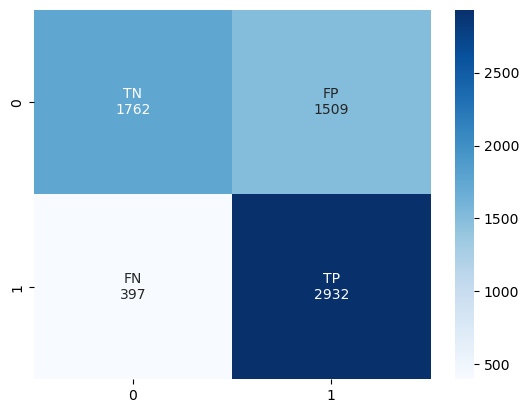

In [13]:
import seaborn as sns
cnf_matrix = confusion_matrix(y_test,y_pred_svm)
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues');

In [14]:

from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

y_pred_lg = logreg.predict(X_test)

print('Logistic Regression accuracy: ', accuracy_score(y_pred_lg, y_test))
print(classification_report(y_test, y_pred_lg))

accuracy:  0.7169696969696969
              precision    recall  f1-score   support

           0       0.72      0.69      0.71      3271
           1       0.71      0.74      0.73      3329

    accuracy                           0.72      6600
   macro avg       0.72      0.72      0.72      6600
weighted avg       0.72      0.72      0.72      6600



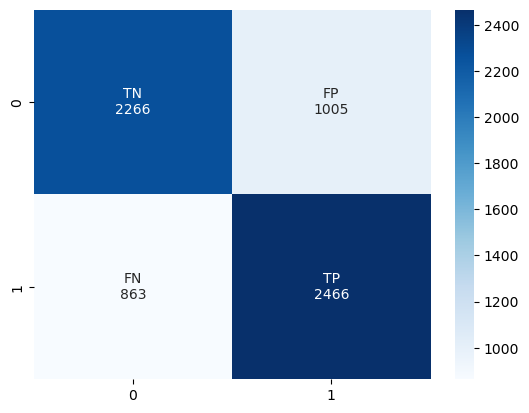

In [15]:
import seaborn as sns
cnf_matrix = confusion_matrix(y_test,y_pred_lg)
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues');

In [16]:
from sklearn.ensemble import RandomForestClassifier

rf = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf',  RandomForestClassifier(n_estimators=600, random_state=21)),
               ])
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print('Random Forest accuracy: ', accuracy_score(y_pred_rf, y_test))
print(classification_report(y_test, y_pred_rf))


accuracy:  0.7225757575757575
              precision    recall  f1-score   support

           0       0.72      0.72      0.72      3271
           1       0.72      0.73      0.73      3329

    accuracy                           0.72      6600
   macro avg       0.72      0.72      0.72      6600
weighted avg       0.72      0.72      0.72      6600



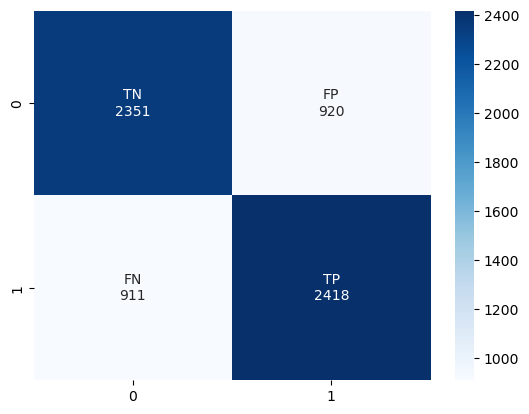

In [17]:
import seaborn as sns
cnf_matrix = confusion_matrix(y_test,y_pred_rf)
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues');

In [19]:
# KNN need to much memory than is avaliable 
''''
from sklearn.neighbors import KNeighborsClassifier

knn = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf',  KNeighborsClassifier(algorithm='auto', leaf_size=15,n_jobs=1, n_neighbors=2)),
               ])
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print('accuracy: ', accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
'''

"'\nfrom sklearn.neighbors import KNeighborsClassifier\n\nknn = Pipeline([('vect', CountVectorizer()),\n                ('tfidf', TfidfTransformer()),\n                ('clf',  KNeighborsClassifier(algorithm='auto', leaf_size=15,n_jobs=1, n_neighbors=2)),\n               ])\nknn.fit(X_train, y_train)\n\ny_pred = knn.predict(X_test)\n\nprint('accuracy: ', accuracy_score(y_pred, y_test))\nprint(classification_report(y_test, y_pred))\n"

In [20]:
from sklearn.neural_network import MLPClassifier

nn = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf',   MLPClassifier(solver='lbfgs', alpha=1e-5, 
                hidden_layer_sizes=(10,10), random_state=42, max_iter = 1000)),
               ])
nn.fit(X_train, y_train)

y_pred_nn = nn.predict(X_test)

print('Neural Network accuracy: ', accuracy_score(y_pred_nn, y_test))
print(classification_report(y_test, y_pred_nn))

accuracy:  0.7159090909090909
              precision    recall  f1-score   support

           0       0.71      0.72      0.72      3271
           1       0.72      0.71      0.72      3329

    accuracy                           0.72      6600
   macro avg       0.72      0.72      0.72      6600
weighted avg       0.72      0.72      0.72      6600



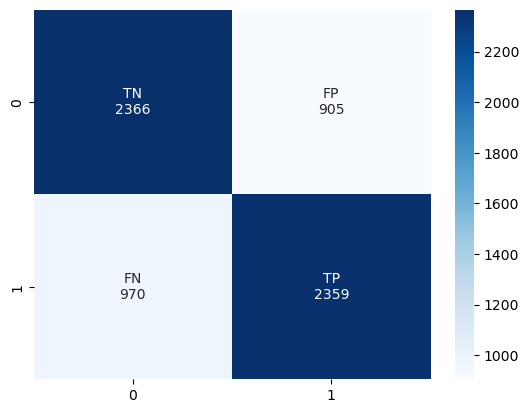

In [21]:
import seaborn as sns
cnf_matrix = confusion_matrix(y_test,y_pred_nn)
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues');

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9a6749d3-7805-4e72-9b13-9d4cebfc5e43' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>